In [23]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/PRMLS/Project')
!ls
#!unzip 'data/cloth.zip' -d 'data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
CAGAN.ipynb  discriminator.h5	generator.h5   instance_normalization.ipynb
data	     discriminator.png	generator.png  out.csv


In [24]:
!pip install import-ipynb
%tensorflow_version 1.x 
import import_ipynb
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

from instance_normalization import InstanceNormalization
import keras
from keras.applications import *
#import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K
from keras.optimizers import RMSprop, SGD, Adam
import time
from IPython.display import clear_output
import cv2
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle
%matplotlib inline

#print("Tensorflow version: ", tf.__version__)
#print(tf.test.gpu_device_name())
print("Keras version: ", keras.__version__)


Keras version:  2.3.1


In [25]:
K.set_learning_phase(1)
channel_axis=-1
channel_first = False

nc_in = 9
nc_out = 4
ngf = 64
ndf = 64
use_lsgan = False
use_nsgan = False # non-saturating GAN
λ =  100

# ========== CAGAN config ==========
nc_G_inp = 9 # [x_im y_im y_j]
nc_G_out = 4 # [alpha, x_i_j(RGB)]
nc_D_inp = 6 # Pos: [x_i, y_i]; Neg1: [G_out(x_i), y_i]; Neg2: [x_i, y_j]
nc_D_out = 1 
gamma_i = 0.1
use_instancenorm = True

imageSize = 128
batchSize = 16 #1
lrD = 2e-4
lrG = 2e-4

In [26]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization

In [27]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)

def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

def instance_norm():
    return InstanceNormalization(axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
  
    input_a = Input(shape=(128, 96, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers+1):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    #_ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, padding='same', name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    #_ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, padding='same', name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_)


"""
Unet or Resnet, which one is better for pix2pix model? 
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/117
Reply from the author:
    UNet gives slightly better results than Resnet in some of the pix2pix applications. 
    We haven't varied the depth of the UNet model, but it might be worth trying.
"""
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True, use_batchnorm=True):
    
    s = isize if fixed_input_size else None
    _ = inputs = Input(shape=(s, int(s*.75), nc_in))
    x_i = Lambda(lambda x: x[:, :, :, 0:3], name='x_i')(inputs)
    y_i = Lambda(lambda x: x[:, :, :, 3:6], name='y_j')(inputs)
    xi_and_y_i = concatenate([x_i, y_i], name = 'xi_yi')
    xi_yi_sz64 = AveragePooling2D(pool_size=2)(xi_and_y_i)
    xi_yi_sz32 = AveragePooling2D(pool_size=4)(xi_and_y_i)
    xi_yi_sz16 = AveragePooling2D(pool_size=8)(xi_and_y_i)
    xi_yi_sz8 = AveragePooling2D(pool_size=16)(xi_and_y_i)
    layer1 = conv2d(64, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer1') (_)
    layer1 = LeakyReLU(alpha=0.2)(layer1)
    layer1 = concatenate([layer1, xi_yi_sz64]) # ==========
    layer2 = conv2d(128, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer2') (layer1)
    if use_instancenorm:
        layer2 = instance_norm()(layer2, training=1)
    else:
        layer2 = batchnorm()(layer2, training=1)
    layer3 = LeakyReLU(alpha=0.2)(layer2)
    layer3 = concatenate([layer3, xi_yi_sz32]) # ==========
    layer3 = conv2d(256, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer3') (layer3)
    if use_instancenorm:
        layer3 = instance_norm()(layer3, training=1)
    else:
        layer3 = batchnorm()(layer3, training=1)
    layer4 = LeakyReLU(alpha=0.2)(layer3)
    layer4 = concatenate([layer4, xi_yi_sz16]) # ==========
    layer4 = conv2d(512, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer4') (layer4)
    if use_instancenorm:
        layer4 = instance_norm()(layer4, training=1)
    else:
        layer4 = batchnorm()(layer4, training=1)
    layer4 = LeakyReLU(alpha=0.2)(layer4)
    layer4 = concatenate([layer4, xi_yi_sz8]) # ==========
    
    layer9 = Conv2DTranspose(256, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init, name = 'layer9')(layer4) 
    layer9 = Cropping2D(((1,1),(1,1)))(layer9)
    if use_instancenorm:
        layer9 = instance_norm()(layer9, training=1)
    else:
        layer9 = batchnorm()(layer9, training=1)
    layer9 = Concatenate(axis=channel_axis)([layer9, layer3])
    layer9 = Activation('relu')(layer9)
    layer9 = concatenate([layer9, xi_yi_sz16]) # ==========
    layer10 = Conv2DTranspose(128, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init, name = 'layer10')(layer9) 
    layer10 = Cropping2D(((1,1),(1,1)))(layer10)
    if use_instancenorm:
        layer10 = instance_norm()(layer10, training=1)
    else:
        layer10 = batchnorm()(layer10, training=1)
    layer10 = Concatenate(axis=channel_axis)([layer10, layer2])
    layer10 = Activation('relu')(layer10)
    layer10 = concatenate([layer10, xi_yi_sz32]) # ==========
    layer11 = Conv2DTranspose(64, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init, name = 'layer11')(layer10) 
    layer11 = Cropping2D(((1,1),(1,1)))(layer11)
    if use_instancenorm:
        layer11 = instance_norm()(layer11, training=1)
    else:
        layer11 = batchnorm()(layer11, training=1)
    layer11 = Activation('relu')(layer11)
        
    layer12 = concatenate([layer11, xi_yi_sz64]) # ==========
    layer12 = Activation('relu')(layer12)
    layer12 = Conv2DTranspose(32, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init, name = 'layer12')(layer12) 
    layer12 = Cropping2D(((1,1),(1,1)))(layer12)
    if use_instancenorm:
        layer12 = instance_norm()(layer12, training=1)
    else:
        layer12 = batchnorm()(layer12, training=1)
    
    layer12 = conv2d(4, kernel_size=4, strides=1, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'out128') (layer12)
    
    alpha = Lambda(lambda x: x[:, :, :, 0:1], name='alpha')(layer12)
    x_i_j = Lambda(lambda x: x[:, :, :, 1:], name='x_i_j')(layer12)
    alpha = Activation("sigmoid", name='alpha_sigmoid')(alpha)
    x_i_j = Activation("tanh", name='x_i_j_tanh')(x_i_j)
    out = concatenate([alpha, x_i_j], name = 'out128_concat')
    
    return Model(inputs=inputs, outputs=[out])   

netGA = UNET_G(imageSize, nc_G_inp, nc_G_out, ngf)
netGA.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 96, 9)   0                                            
__________________________________________________________________________________________________
x_i (Lambda)                    (None, 128, 96, 3)   0           input_3[0][0]                    
__________________________________________________________________________________________________
y_j (Lambda)                    (None, 128, 96, 3)   0           input_3[0][0]                    
__________________________________________________________________________________________________
layer1 (Conv2D)                 (None, 64, 48, 64)   9216        input_3[0][0]                    
____________________________________________________________________________________________

In [28]:
netDA = BASIC_D(nc_D_inp, ndf, use_sigmoid = True)
netDA.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 96, 6)        0         
_________________________________________________________________
First (Conv2D)               (None, 64, 48, 64)        6208      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 64, 48, 64)        0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, 32, 24, 128)       131072    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 24, 128)       512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 24, 128)       0         
_________________________________________________________________
pyramid.2 (Conv2D)           (None, 16, 12, 256)       5242

In [29]:
def cycle_variables(netG1):
    """
    Intermidiate params:
        x_i: human w/ cloth i, shape=(128,96,3)
        y_i: stand alone cloth i, shape=(128,96,3)
        y_j: stand alone cloth j, shape=(128,96,3)
        alpha: mask for x_i_j, shape=(128,96,1)
        x_i_j: generated fake human swapping cloth i to j, shape=(128,96,3)
    
    Out:
        real_input: concat[x_i, y_i, y_j], shape=(128,96,9)
        fake_output: masked_x_i_j = alpha*x_i_j + (1-alpha)*x_i, shape=(128,96,3)
        rec_input: output of the second generator (generating image similar to x_i), shape=(128,96,3)
        fn_generate: a path from input to G_out and cyclic G_out
    """
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]

    x_i = Lambda(lambda x: x[:,:,:, 0:3])(real_input)
    y_i = Lambda(lambda x: x[:,:,:, 3:6])(real_input)
    y_j = Lambda(lambda x: x[:,:,:, 6:])(real_input)
    alpha = Lambda(lambda x: x[:,:,:, 0:1])(fake_output)
    x_i_j = Lambda(lambda x: x[:,:,:, 1:])(fake_output)
    
    fake_output = x_i_j 
    concat_input_G2 = concatenate([fake_output, y_j, y_i], axis=-1) # swap y_i and y_j
    rec_input = netG1([concat_input_G2])
    rec_alpha = Lambda(lambda x: x[:,:,:, 0:1])(rec_input)
    rec_x_i_j = Lambda(lambda x: x[:,:,:, 1:])(rec_input)
    rec_input = rec_alpha*rec_x_i_j + (1-rec_alpha)*fake_output
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate, alpha

real_A, fake_B, rec_A, cycleA_generate, alpha_A = cycle_variables(netGA)

In [30]:
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

In [31]:
def D_loss(netD, real, fake, rec):
    #x_i, y_i, y_j = tf.split(real, [3, 3, 3], 3)    
    x_i = Lambda(lambda x: x[:,:,:, 0:3])(real)
    y_i = Lambda(lambda x: x[:,:,:, 3:6])(real)
    y_j = Lambda(lambda x: x[:,:,:, 6:])(real)
    x_i_j = fake  
    
    output_real = netD(concatenate([x_i, y_i])) # positive sample
    output_fake = netD(concatenate([x_i_j, y_j])) # negative sample
    output_fake2 = netD(concatenate([x_i, y_j])) # negative sample 2
    
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))    
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_D_fake2 = loss_fn(output_fake2, K.zeros_like(output_fake2)) # New loss term for discriminator    
    
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    
    loss_D = loss_D_real+(loss_D_fake+loss_D_fake2)
    loss_cyc = K.mean(K.abs(rec-x_i)) # cycle loss
    return loss_D, loss_G, loss_cyc

In [32]:
loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_B, rec_A)
loss_cyc = loss_cycA
loss_id = K.mean(K.abs(alpha_A)) # loss of alpha

loss_G = loss_GA + 1*(1*loss_cyc + gamma_i*loss_id)
loss_D = loss_DA*2

weightsD = netDA.trainable_weights
weightsG = netGA.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A],[loss_DA/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG, [], loss_G)
netG_train = K.function([real_A], [loss_GA, loss_cyc], training_updates)
print(loss_GA)

Tensor("Neg_7:0", shape=(), dtype=float32)


In [33]:
def load_data(file_pattern):
    return glob.glob(file_pattern)

def crop_img(img, large_size, small_size):
    # only apply DA to human images
    img_width = small_size[0]
    img_height = small_size[1]
    diff_size = (large_size[0]-small_size[0], large_size[1]-small_size[1])
    
    x_range = [i for i in range(diff_size[0])]
    y_range = [j for j in range(diff_size[1])]
    x0 = np.random.choice(x_range)
    y0 = np.random.choice(y_range)
    
    img = np.array(img)
    
    img = img[y0: y0+img_height, x0: x0+img_width, :]
    
    return img

def read_image(fn):
    cropped_size = (96,128)
    
    # Load human picture
    im = Image.open(fn).convert('RGB')
    im = im.resize( cropped_size, Image.BILINEAR )    
    
    arr = np.array(im)/255*2-1
    img_x_i = arr
        
    # Load article picture y_i
    fn_y_i = fn[:-5] + "1.jpg"
    fn_y_i = fn_y_i[:fn_y_i.rfind("/")-5] + "cloth/" + fn_y_i.split("/")[-1]

    im = Image.open(fn_y_i).convert('RGB')
    im = im.resize(cropped_size, Image.BILINEAR )    
   
    arr = np.array(im)/255*2-1
    img_y_i = arr
    if channel_first:        
        img_y_i = np.moveaxis(img_y_i, 2, 0)
    
    # Load article picture y_j randomly
    fn_y_j = np.random.choice(filenames_5)
    while (fn_y_j == fn_y_i):
        fn_y_j = np.random.choice(filenames_5)

    im = Image.open(fn_y_j).convert('RGB')
    im = im.resize( cropped_size, Image.BILINEAR )
    
    arr = np.array(im)/255*2-1
    img_y_j = arr
    if randint(0,1): 
        img_y_j=img_y_j[:,::-1]
    if channel_first:        
        img_y_j = np.moveaxis(img_y_j, 2, 0)        
    
    if randint(0,1): # prevent disalign of the graphic on t-shirts and human when fplipping
        img_x_i=img_x_i[:,::-1]
        img_y_i=img_y_i[:,::-1]
    
    img = np.concatenate([img_x_i, img_y_i, img_y_j], axis=-1)    
    assert img.shape[-1] == 9
    
    return img

In [34]:
data = "data/viton_resize/train"
train_A = load_data('{}/image/*.jpg'.format(data))

filenames_1 = load_data('{}/image/*.jpg'.format(data))
filenames_5 = load_data('{}/cloth/*.jpg'.format(data))

print(len(train_A))

5340


In [35]:
print(len(train_A))
print(len(filenames_1))
print(len(filenames_5))

5340
5340
14221


In [36]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, batchsize):
    batchA=minibatch(dataA, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        tmpsize = yield ep1, A

In [37]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    #print (int_X.shape)
    
    if X.shape[-1] == 9:
      img_x_i = int_X[:,:,:,:3]
      img_y_i = int_X[:,:,:,3:6]
      img_y_j = int_X[:,:,:,6:9]
      int_X = np.concatenate([img_x_i, img_y_i, img_y_j], axis=1)
    else:
      int_X = int_X.reshape(-1,128,96, 3)

    int_X = int_X.reshape(rows, -1, 128, 96,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)

    display(Image.fromarray(int_X))

In [38]:
def showG(A):
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    arr = np.concatenate([A[:,:,:,:3], A[:,:,:,3:6], A[:,:,:,6:9], rA[0], rA[1]])
    showX(arr,5)  

[149/150][49500] Loss_D: 0.114529 Loss_G: 5.887291 loss_cyc: 0.136624 25995.62056016922


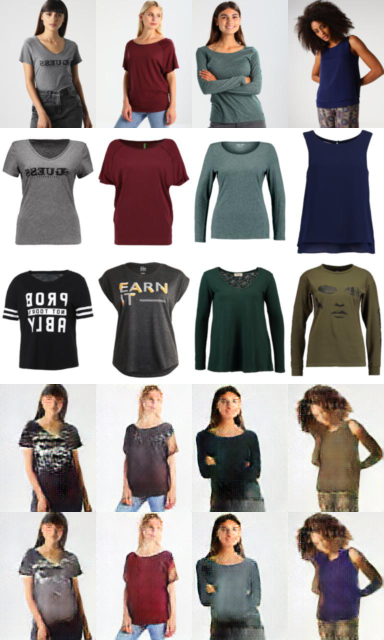

[149/150][49550] Loss_D: 0.126278 Loss_G: 5.885148 loss_cyc: 0.137770 26015.458550691605


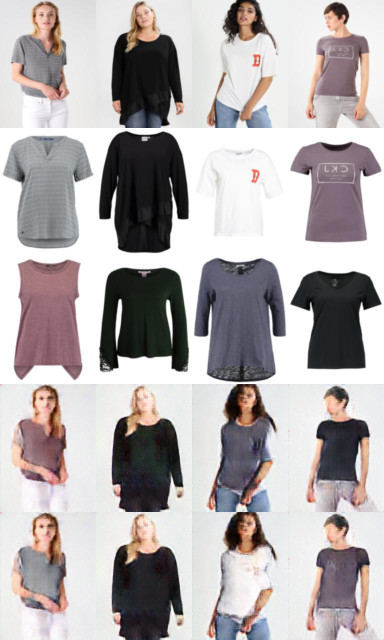

[149/150][49600] Loss_D: 0.291109 Loss_G: 5.179757 loss_cyc: 0.140025 26035.278730154037


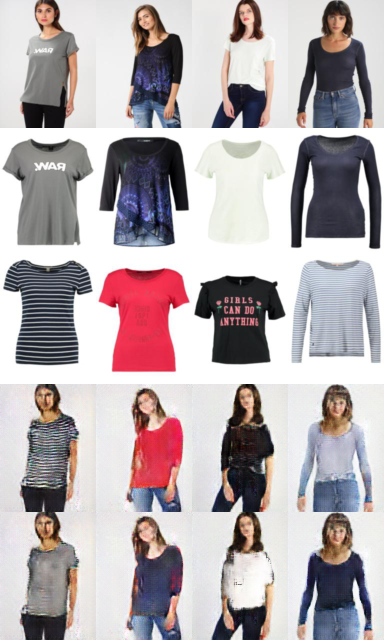

[149/150][49650] Loss_D: 0.255213 Loss_G: 5.899861 loss_cyc: 0.136098 26055.106594085693


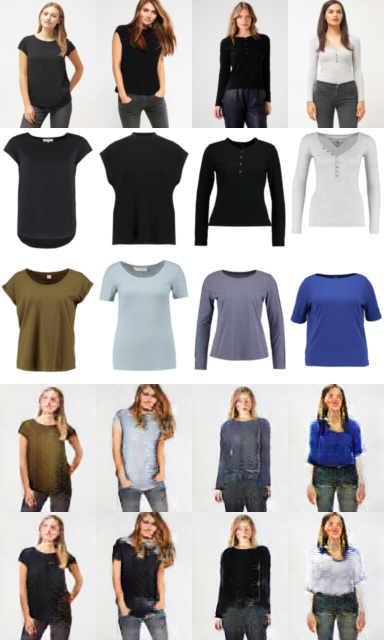

[149/150][49700] Loss_D: 0.095607 Loss_G: 5.781504 loss_cyc: 0.138079 26074.898285865784


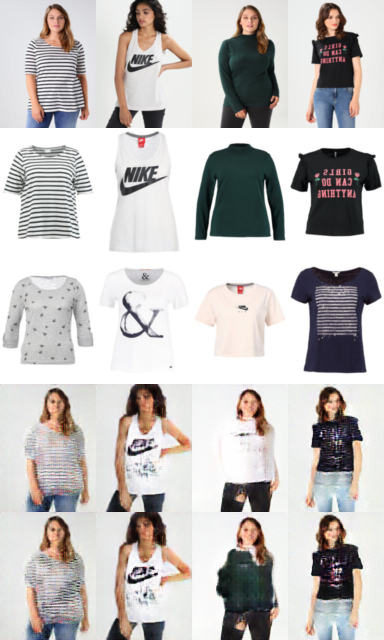

[149/150][49750] Loss_D: 0.137927 Loss_G: 5.454977 loss_cyc: 0.138697 26094.745754003525


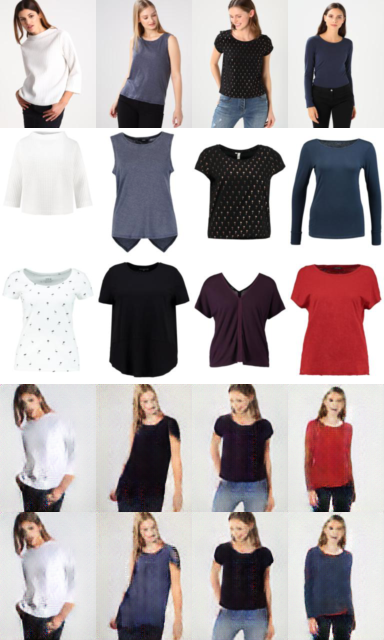

[149/150][49800] Loss_D: 0.316544 Loss_G: 6.063381 loss_cyc: 0.137015 26114.512127161026


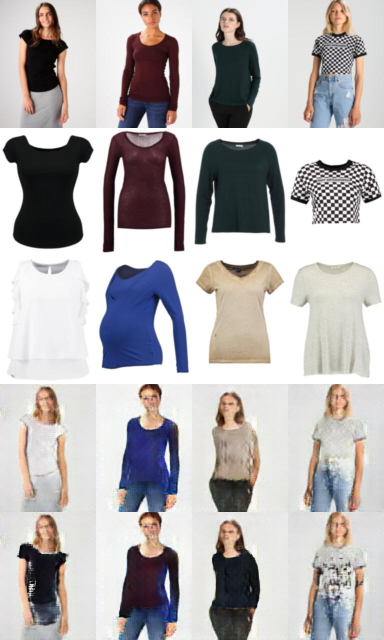

In [41]:
t0 = time.time()
niter = 150
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errDA_sum = errC_sum = 0

display_iters = 50
train_batch = minibatchAB(train_A, batchSize)
current_epoch = 0
gen_loss=[]
cycle_loss=[]
disc_loss=[]
while epoch < 150: 
    epoch, A = next(train_batch)   
    errDA  = netD_train([A])
    errDA_sum +=errDA[0]

    # epoch, trainA, trainB = next(train_batch)
    errGA, errCyc = netG_train([A])
    errGA_sum += errGA
    errCyc_sum += errCyc
    gen_iterations+=1
    if (epoch == current_epoch+1):
        gen_loss.append(errGA)
        cycle_loss.append(errCyc)
        disc_loss.append(errDA)
        current_epoch+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(10*display_iters)==0: # clear_output every 500 iters
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_cyc: %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters,
           errGA_sum/display_iters, errCyc_sum/display_iters), time.time()-t0)        
        _, A = train_batch.send(4)
        showG(A)        
        errCyc_sum = errGA_sum = errDA_sum = errC_sum = 0

import csv
wtr = csv.writer(open ('generator.csv', 'w'), delimiter=',', lineterminator='\n')
for x in gen_loss : wtr.writerow ([x])

wtr_cyc = csv.writer(open ('cycle.csv', 'w'), delimiter=',', lineterminator='\n')
for y in cycle_loss : wtr_cyc.writerow ([y])

wtr_disc = csv.writer(open ('discriminator.csv', 'w'), delimiter=',', lineterminator='\n')
for z in disc_loss : wtr_disc.writerow ([z])

In [44]:
print(gen_loss)
print(cycle_loss)
print(disc_loss)

[0.7510627, 0.9463806, 1.3402418, 2.0817747, 1.4691728, 2.1575005, 1.0383557, 3.3976877, 3.4271224, 1.4236053, 2.656462, 2.068487, 1.3277688, 1.6436892, 3.5477922, 1.9556252, 1.81292, 2.4262094, 5.4347477, 3.750346, 5.2907987, 2.7378666, 3.23452, 2.4055917, 3.0328426, 3.4969552, 4.6622863, 2.9560392, 3.8568637, 1.2976261, 3.064006, 2.9305327, 3.5248115, 3.47155, 4.6729302, 3.3564155, 3.4433105, 4.477646, 2.7674634, 2.8036501, 2.0909178, 4.6401973, 2.556496, 3.562875, 3.7117736, 1.671718, 6.442289, 4.550402, 4.2954297, 3.3129911, 5.4861083, 3.6550229, 1.7590781, 7.063022, 5.0512886, 3.196934, 5.3127475, 4.4408937, 5.701448, 1.1022822, 2.844555, 3.8732884, 3.7649047, 4.9921374, 3.678528, 4.037471, 4.8373313, 3.0127935, 4.5977087, 1.650325, 3.882878, 4.485855, 2.4580653, 3.627699, 4.481193, 2.39615, 3.5787594, 6.2656574, 6.3117795, 3.6699505, 4.97967, 4.834847, 3.956887, 2.9718666, 9.751492, 5.227451, 2.8191216, 4.716518, 5.3521113, 6.306272, 5.032246, 7.6563973, 4.839941, 2.5116773, 3.32

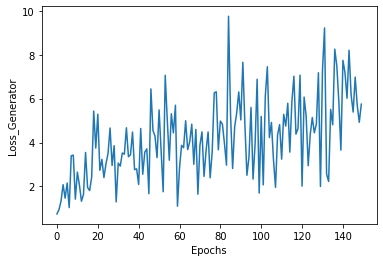

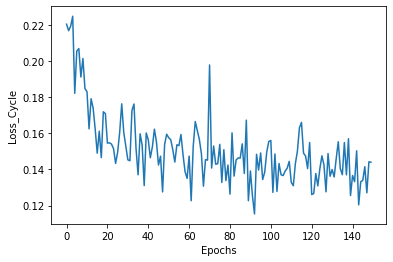

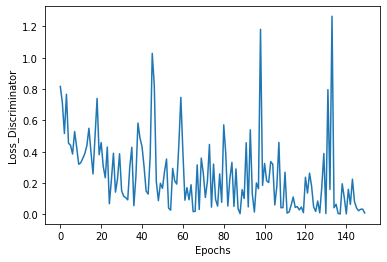

In [50]:
x_coordinate = [ i for i in range(len(gen_loss)) ]
plt.plot(x_coordinate,gen_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss_Generator")
plt.show()

x_coordinate = [ i for i in range(len(cycle_loss)) ]
plt.plot(x_coordinate,cycle_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss_Cycle")
plt.show()

x_coordinate = [ i for i in range(len(disc_loss)) ]
plt.plot(x_coordinate,disc_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss_Discriminator")
plt.show()


In [45]:
netDA.save('discriminator.h5')
netGA.save('generator.h5')

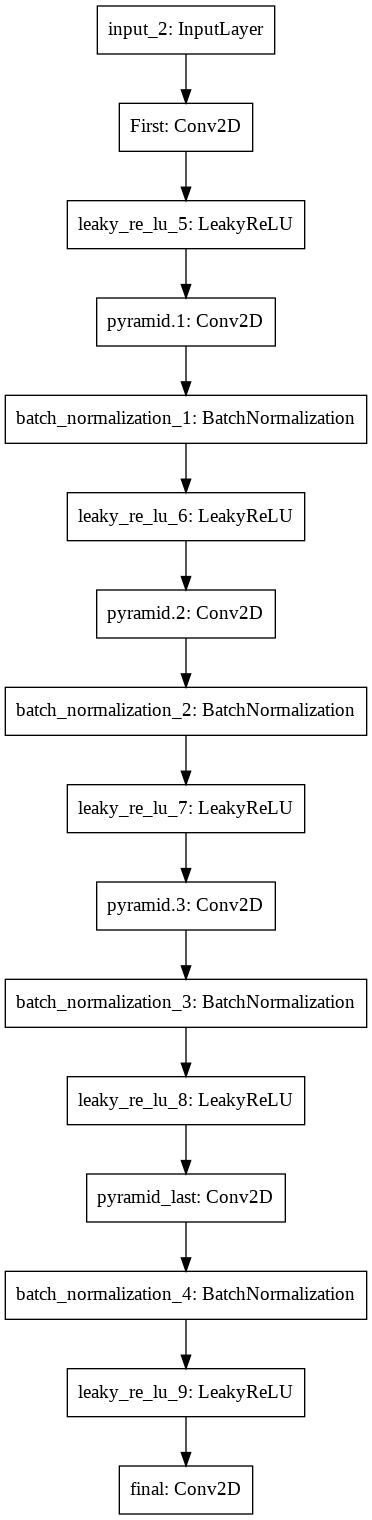

In [ ]:
from keras.utils import plot_model
plot_model(load_DA_model, to_file='discriminator.png')